# Classical Swine Fever - Japan Outbreak 2018/2019 - Data Analysis

This workbook analyses and visualizes data on the current outbreak of classical swine fever (CSF) in Japan. 

**Background for project:**

Until September 2018, CSF had been eradicated in Japan since 1992. On September 3rd 2018, cases of CSF on a farm in Gifu Prefecture was once more detected. Since then the Japanese authorities has closely monitored the situation and put in extra precautions to prevent the disease from spreading.

The new updates on outbreaks is only published by the Japanese Ministry for Agriculture, Fisheries and Forestry (MAFF) in Japanese.

The World Organisation for Animal Health: [oie.int](http://www.oie.int/) receives the information from MAFF and publishes a weakly report in English (Although, due to Japanese holidays it is not always published regularly). The reports are published in the following format: [OIE - Immediate notification (09/09/2018)](http://www.oie.int/wahis_2/public/wahid.php/Reviewreport/Review?reportid=27871)

**Data Structuring**

In the workbook *CSF data generation* I've scraped the html code from all the reports and restructured the info into a dataframe. Futhermore I've collected the coordinates of the outbreaks with GeoLocator so I can make a map. I then save it into a .csv file. For scraping and restructuring method see *CSF data generation*. The running of the code is quite cumbersome, so generating the dataset takes around 15-20 min. 

**Data Analysis**

In this workbook I analyze the data generated in *CSF data generation* by:
- Making a barplot showing outbreaks over time divided on oubreaks among domestic pig (swine) and wild boar
- Making a map plotting all outbreaks


In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import pyplot
from matplotlib import dates

import matplotlib.dates as mdates
import matplotlib.ticker as plticker
from matplotlib.dates import DateFormatter
import time

from mpl_toolkits.basemap import Basemap


In [2]:
# I create a folder for the figures:
if not os.path.exists('Figures'):
    os.mkdir('Figures')

In [3]:
# I read the .csv file created in CSF data generation into a pandas dataframe:
csf = pd.read_csv('CSF_Japan_data.csv')

print(csf.head(2))

          ID  City Prefecture        Date                       Species  \
0  on.1  (1)  Gifu       Gifu  2018-09-03                         Swine   
1        1.1  Gifu       Gifu  2018-09-13  Wild boar:Sus scrofa(Suidae)   

   Susceptibles  Cases  Deaths Geo_Lookup   Latitude   Longitude  
0           610     29      29  Gifu Gifu  35.423095  136.762753  
1             0      1       1  Gifu Gifu  35.423095  136.762753  


In [4]:
# I create dummy variables for swine and wild boar:
species_dummy = pd.get_dummies(csf['Species'])
# I merge the two dataframes:
csf = pd.concat([csf, species_dummy], axis=1)
csf.head()

,ID,City,Prefecture,Date,Species,Susceptibles,Cases,Deaths,Geo_Lookup,Latitude,Longitude,Swine,Wild boar:Sus scrofa(Suidae)
0,on.1 (1),Gifu,Gifu,2018-09-03,Swine,610,29,29,Gifu Gifu,35.423095,136.762753,1,0
1,1.1,Gifu,Gifu,2018-09-13,Wild boar:Sus scrofa(Suidae),0,1,1,Gifu Gifu,35.423095,136.762753,0,1
2,2.1,Gifu,Gifu,2018-09-15,Wild boar:Sus scrofa(Suidae),0,1,1,Gifu Gifu,35.423095,136.762753,0,1
3,2.2,Gifu,Gifu,2018-09-18,Wild boar:Sus scrofa(Suidae),0,3,3,Gifu Gifu,35.423095,136.762753,0,1
4,2.3,Gifu,Gifu,2018-09-21,Wild boar:Sus scrofa(Suidae),0,1,1,Gifu Gifu,35.423095,136.762753,0,1


In [5]:
# Grouping by 'Date' I can make a timeline plotting number of outbreaks pr. day:
grouped = csf.groupby('Date')

csf_count = grouped.count()
csf_grouped = grouped.sum()

csf_grouped['Outbreaks'] = csf_count['ID']
csf_grouped.reset_index(inplace=True)

print('Number of dates with outbreaks:', len(csf_grouped))
csf_grouped.head(5)

Number of dates with outbreaks: 142


,Date,Susceptibles,Cases,Deaths,Latitude,Longitude,Swine,Wild boar:Sus scrofa(Suidae),Outbreaks
0,2018-09-03,610,29,29,35.423095,136.762753,1,0,1
1,2018-09-13,0,1,1,35.423095,136.762753,0,1,1
2,2018-09-15,0,1,1,35.423095,136.762753,0,1,1
3,2018-09-18,0,3,3,35.423095,136.762753,0,1,1
4,2018-09-21,0,1,1,35.423095,136.762753,0,1,1


In [6]:
# Now there are no duplicate dates, so I can change the format type of the date to a 'datetime'-format:
csf_grouped['datetime'] = pd.to_datetime(csf_grouped['Date'].astype(str), format='%Y-%m-%d')
csf_grouped = csf_grouped.set_index('datetime')
csf_grouped.drop(['Date'], axis=1, inplace=True)

print(csf_grouped.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 142 entries, 2018-09-03 to 2019-05-16
Data columns (total 8 columns):
Susceptibles                    142 non-null int64
Cases                           142 non-null int64
Deaths                          142 non-null int64
Latitude                        142 non-null float64
Longitude                       142 non-null float64
Swine                           142 non-null uint8
Wild boar:Sus scrofa(Suidae)    142 non-null uint8
Outbreaks                       142 non-null int64
dtypes: float64(2), int64(4), uint8(2)
memory usage: 8.0 KB
None


In [7]:
# All dates without an outbreak and no datapoints gets a datapoint with the value zero:
date_min = csf_grouped.index.min()
date_max = csf_grouped.index.max()

print('First observation:', date_min)
print('Last observation:', date_max)

idx = pd.date_range(date_min, date_max)

csf_grouped.index = pd.DatetimeIndex(csf_grouped.index)

csf_grouped = csf_grouped.reindex(idx, fill_value=0)
csf_grouped['Date'] = pd.to_datetime(csf_grouped.index)

csf_grouped = csf_grouped
print('Interval in number of days:', len(csf_grouped))

First observation: 2018-09-03 00:00:00
Last observation: 2019-05-16 00:00:00
Interval in number of days: 256


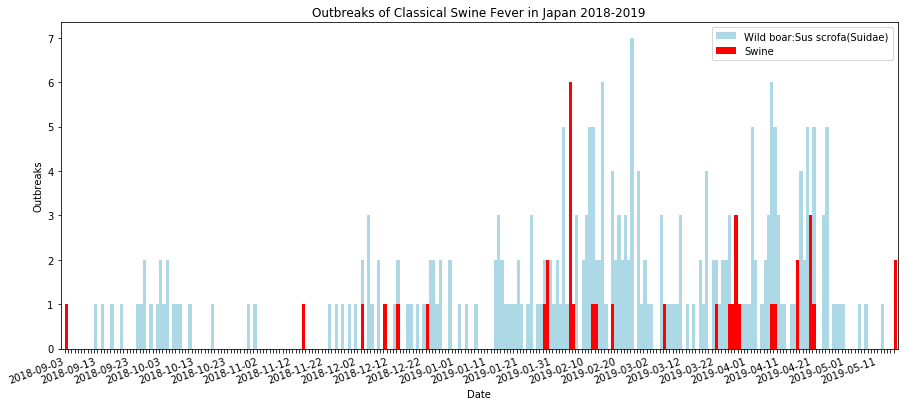

In [10]:
# We can now make the barplot showing outbreaks over time
fig, ax = plt.subplots(figsize = (15,6))
fig = csf_grouped.plot(x="Date", y=["Wild boar:Sus scrofa(Suidae)","Swine"], kind="bar", color=['lightblue','red'], width=2, ax=ax)

n = 10  # Keeps every 7th label
[l.set_visible(False) for (i,l) in enumerate(ax.xaxis.get_ticklabels()) if i % n != 0]

x = csf_grouped['Date']

ax.set_xticklabels(x.dt.date, rotation=20, horizontalalignment = 'right')
plt.title('Outbreaks of Classical Swine Fever in Japan 2018-2019')
plt.ylabel('Outbreaks')
plt.xlabel('Date')
plt.savefig('Figures/outbreaks.svg', bbox_inches = 'tight', dpi=1000)
plt.savefig('Figures/outbreaks.png', bbox_inches = 'tight', dpi=1000)
plt.show()


In [11]:
# A big rise in outbreaks happens the 5th of February. I examine:
date = csf['Date'] == '2019-02-05'
date = csf[date]
date

,ID,City,Prefecture,Date,Species,Susceptibles,Cases,Deaths,Geo_Lookup,Latitude,Longitude,Swine,Wild boar:Sus scrofa(Suidae)
89,15.13 (8),Ena,Gifu,2019-02-05,Swine,4284,0,0,Ena Gifu,35.449809,137.412827,1,0
90,15.14 (8),Miyada,Nagano,2019-02-05,Swine,2444,0,0,Miyada Nagano,35.774827,137.874269,1,0
91,15.15 (8),Toyota,Aichi,2019-02-05,Swine,6640,5,0,Toyota Aichi,35.151950,137.301478,1,0
92,15.16 (8),Higashi,Osaka,2019-02-05,Swine,737,0,0,Higashi Osaka,34.678147,135.597728,1,0
93,15.17 (8),Omihachiman,Shiga,2019-02-05,Swine,700,10,0,Omihachiman Shiga,35.152791,136.068736,1,0
94,15.18 (8),Tahara,Aichi,2019-02-05,Swine,1600,5,0,Tahara Aichi,34.639112,137.183207,1,0
103,16.9,Kani,Gifu,2019-02-05,Wild boar:Sus scrofa(Suidae),0,1,0,Kani Gifu,35.426109,137.061317,0,1


From the ID number I can see the outbreaks are described in report nr. 15: 
February 5th, it was confirmed, that a farm in the city of Toyota in Aichi prefecture had an outbreak of CSF. It had just delivered piglets to 5 other farms in Aichi, Nagano, Gifu, Shiga and Osaka prefecture. All the farms who had received the piglets were examined and at the affected farms all pigs were terminated. 

## Creating the map

The only information of location given in the data collected was the city and prefecture. Two farms in the same city, will be shown at the same location, even though the exact location might be different.

In [13]:
# First I look at the number of unique locations. 
grouped = csf.groupby('Geo_Lookup')

csf_count = grouped.count()
csf_grouped = grouped.sum()

csf_grouped['Outbreaks'] = csf_count['ID']
csf_grouped.reset_index(inplace=True)

print('Number of unique places:', len(csf_grouped))

csf_grouped

Number of unique places: 30


,Geo_Lookup,Susceptibles,Cases,Deaths,Latitude,Longitude,Swine,Wild boar:Sus scrofa(Suidae),Outbreaks
0,Ena Gifu,17534,40,23,567.196950,2198.605230,3,13,16
1,Gifu Gifu,849,84,51,1204.385227,4649.933588,4,30,34
2,Gujo Gifu,0,14,6,214.490502,821.785857,0,6,6
3,Hichiso Gifu,0,9,3,213.255467,822.719111,0,6,6
4,Higashi Osaka,737,0,0,34.678147,135.597728,1,0,1
5,Inuyama Aichi,0,12,1,353.609690,1369.840180,0,10,10
6,Kakamigahara Gifu,1662,30,12,601.792913,2326.425602,1,16,17
7,Kani Gifu,10,36,8,991.931060,3837.716865,1,27,28
8,Kasugai Aichi,0,4,2,141.095216,548.029836,0,4,4
9,Kawabe Gifu,0,22,1,532.297688,2056.022365,0,15,15


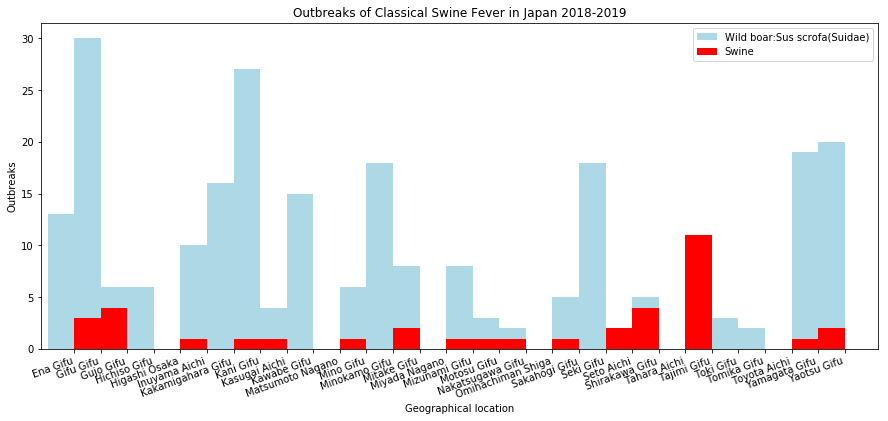

In [14]:
# A figure displaying outbreaks per location:
fig, ax = plt.subplots(figsize = (15,6))
fig = csf_grouped.plot(x="Geo_Lookup", y=["Wild boar:Sus scrofa(Suidae)","Swine"], kind="bar", color=['lightblue','red'], width=2, ax=ax)

x = csf_grouped['Geo_Lookup']

ax.set_xticklabels(x, rotation=20, horizontalalignment = 'right')
plt.title('Outbreaks of Classical Swine Fever in Japan 2018-2019')
plt.ylabel('Outbreaks')
plt.xlabel('Geographical location')
plt.savefig('Figures/barplot_cities.svg', bbox_inches = 'tight', dpi=1000)
plt.savefig('Figures/barplot_cities.png', bbox_inches = 'tight', dpi=1000)
plt.show()


In [15]:
# I also examine the affected prefectures:
grouped = csf.groupby('Prefecture')

csf_count = grouped.count()
csf_grouped = grouped.sum()

csf_grouped['Outbreaks'] = csf_count['ID']
csf_grouped.reset_index(inplace=True)

print('Affected prefectures:', len(csf_grouped))
csf_grouped

Affected prefectures: 5


,Prefecture,Susceptibles,Cases,Deaths,Latitude,Longitude,Swine,Wild boar:Sus scrofa(Suidae),Outbreaks
0,Aichi,49175,46,3,1051.851024,4112.651519,16,14,30
1,Gifu,40576,579,188,9110.273166,35210.041453,17,240,257
2,Nagano,2482,0,0,72.013032,275.842983,2,0,2
3,Osaka,737,0,0,34.678147,135.597728,1,0,1
4,Shiga,700,10,0,35.152791,136.068736,1,0,1


April 27th 2019: From the table above it can be seen, that almost all outbreaks are in the prefectures Gifu and Aichi. The only outbreaks in Nagano, Osaka and Shiga are the outbreaks from February 5th. There are no other outbreaks in those prefectures. This might that the effort to keep the disease from spreading has been somehow succesfull until now.

In [16]:
# To distinguish between outbreaks among domestic pig (swine) and wild boar in my map I make two new dataframes:
swine = csf['Species'] == 'Swine'
df_swine = csf[swine]
boar = csf['Species'] == 'Wild boar:Sus scrofa(Suidae)'
df_boar = csf[boar]

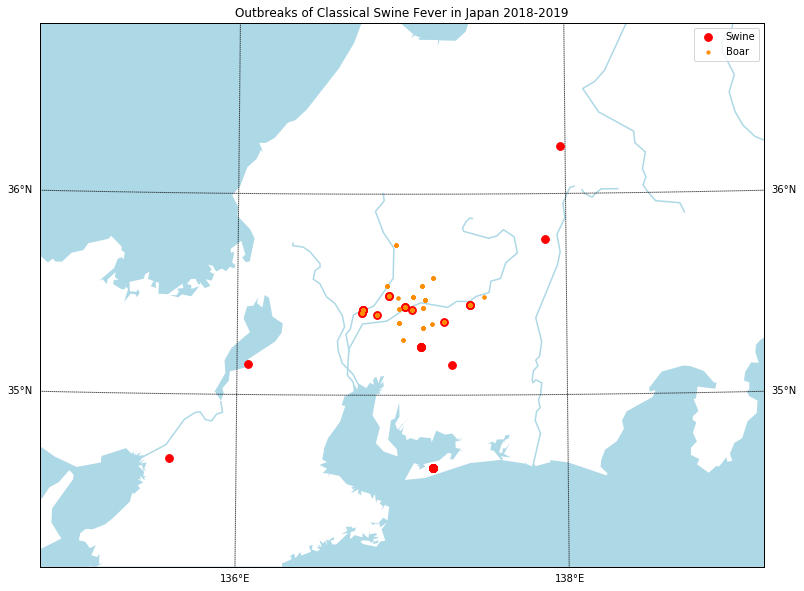

In [24]:
## Map of geographical locations of the outbreaks

# The data to be dots of swine outbreaks
swine_lon = df_swine['Longitude'].values.tolist()
swine_lat = df_swine['Latitude'].values.tolist()
# The data to be dots of boar outbreaks
boar_lon = df_boar['Longitude'].values.tolist()
boar_lat = df_boar['Latitude'].values.tolist()

# The generation of the map:   
fig, ax1 = plt.subplots(figsize=(15, 10))
mm = Basemap(
    width=400000, height=300000,
    resolution='i',
    projection='aea',
    ellps='WGS84',
    lat_1=34.5, lat_2=35.5,
    lat_0=35.5, lon_0=137.)
rivers = mm.drawrivers(color='lightblue', linewidth=1.5)
continents = mm.fillcontinents(
    color='white',
    lake_color='lightblue')
bound= mm.drawmapboundary(fill_color='lightblue')
countries = mm.drawcountries()
merid = mm.drawmeridians(
    np.arange(-180, 180, 2), 
    labels=[False, False, False, True])
parall = mm.drawparallels(
    np.arange(0, 80), 
    labels=[True, True, False, False])

# The dotsots
x_swine, y_swine = mm(swine_lon, swine_lat)
swine = mm.scatter(x_swine, y_swine, 60, color='red', zorder=10, label='Swine')
x_boar, y_boar = mm(boar_lon, boar_lat)
boar = mm.scatter(x_boar, y_boar, 10, color='darkorange', zorder=10, label='Boar')

#The printing
plt.legend()
plt.title('Outbreaks of Classical Swine Fever in Japan 2018-2019')

# I save both as .png and .svg as to have a high quality format and less heavy .png file:
plt.savefig('Figures/map.png', bbox_inches = 'tight',dpi=1000)
plt.savefig('Figures/map.svg', bbox_inches = 'tight',dpi=1000)
plt.show()